# Accident Analysis in Barcelona: Exploring Causes and Trends

In this notebook, I will analyze accident data managed by the Urban Guard in Barcelona. The process will involve data cleaning, exploratory data analysis (EDA) to identify key trends and insights, and the implementation of a modeling pipeline to evaluate factors contributing to accidents.

The ultimate goal is to derive actionable insights that can inform safety improvements in the city.

# Imports

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime

from UTILS import InitialEDA, PreprocessingStarter, FeatureEngineering

import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely import wkt
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from IPython.display import Image
import time
import os

from sklearn.metrics import mean_absolute_error
import lightgbm as lgb 
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

# EDA

## Data Cleaning

In [82]:
data = pd.read_csv("./data/2023_accidents_causa_conductor_gu_bcn_.csv")

data.columns = data.columns.str.strip() #Num_postal had a typo

data.head()

,Numero_expedient,Codi_districte,Nom_districte,Codi_barri,Nom_barri,Codi_carrer,Nom_carrer,Num_postal,Descripcio_dia_setmana,NK_Any,Mes_any,Nom_mes,Dia_mes,Hora_dia,Descripcio_torn,Descripcio_causa_mediata,Coordenada_UTM_X_ED50,Coordenada_UTM_Y_ED50,Longitud_WGS84,Latitud_WGS84
0,2023S000699,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Dissabte,2023,2,Febrer,4,16,Tarda,Manca d'atenció a la conducció,430443.36,4585232.00,2.166596,41.413783
1,2023S005197,-1,Desconegut,-1,Desconegut,-1,Estatut de Catalunya ...,11,Divendres,2023,9,Setembre,1,13,Matí,No respectar distàncies,429493.73,4587108.15,2.155015,41.430598
2,2023S007430,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Divendres,2023,12,Desembre,15,11,Matí,No respectar distàncies,430443.36,4585232.00,2.166596,41.413783
3,2023S000961,-1,Desconegut,-1,Desconegut,-1,Amílcar ...,120,Dissabte,2023,1,Gener,28,14,Tarda,No respectat pas de vianants,430955.45,4586335.10,2.172596,41.423762
4,2023S006486,-1,Desconegut,-1,Desconegut,-1,Augusta / Hort de la Vila ...,NaN,Dijous,2023,11,Novembre,2,14,Tarda,Desobeir semàfor,426883.33,4583690.92,2.124189,41.399587


In [83]:
# There are lots of typos
eda = InitialEDA()

cat_cols = eda.get_categorical(data)

# Clean and replace spaces in each categorical column
for col in cat_cols:
    if data[col].isnull().any():
        data[col] = data[col].fillna('')  # Fill NaNs with an empty string
    data[col] = data[col].str.strip()          # Remove leading/trailing whitespace
    data[col] = data[col].str.replace(' ', '_')  # Replace spaces with underscores

In [84]:
print(f"Number of duplicate rows: {data.duplicated().sum()}")
print(f"Number of duplicate expedient: {data['Numero_expedient'].duplicated().sum()}")

# Duplicated expedient seem to be same accident but one has "Altres" in Descripcio_causa_mediata

Number of duplicate rows: 0
Number of duplicate expedient: 1176


In [85]:
data = data[~((data['Descripcio_causa_mediata'] == 'Altres') & 
                      data.duplicated(subset=['Numero_expedient'], keep=False))]

# Rest of duplicates are same accident with different cause. Just keep one
print(f"Number of duplicate expedient: {data['Numero_expedient'].duplicated().sum()}")

data.drop_duplicates(subset=['Numero_expedient'], keep='first', inplace=True)
print(f"Number of duplicate expedient after cleaning: {data['Numero_expedient'].duplicated().sum()}")

Number of duplicate expedient: 426
Number of duplicate expedient after cleaning: 0


Drop unknown districts

In [86]:
data = data[data['Nom_districte'] != 'Desconegut']

In [87]:
for col in data.columns:
    print("Nr. of unique values in", col, "is", data[col].nunique())

Nr. of unique values in Numero_expedient is 7631
Nr. of unique values in Codi_districte is 10
Nr. of unique values in Nom_districte is 10
Nr. of unique values in Codi_barri is 73
Nr. of unique values in Nom_barri is 73
Nr. of unique values in Codi_carrer is 1073
Nr. of unique values in Nom_carrer is 1040
Nr. of unique values in Num_postal is 1908
Nr. of unique values in Descripcio_dia_setmana is 7
Nr. of unique values in NK_Any is 1
Nr. of unique values in Mes_any is 12
Nr. of unique values in Nom_mes is 12
Nr. of unique values in Dia_mes is 31
Nr. of unique values in Hora_dia is 24
Nr. of unique values in Descripcio_torn is 3
Nr. of unique values in Descripcio_causa_mediata is 16
Nr. of unique values in Coordenada_UTM_X_ED50 is 4756
Nr. of unique values in Coordenada_UTM_Y_ED50 is 4752
Nr. of unique values in Longitud_WGS84 is 4770
Nr. of unique values in Latitud_WGS84 is 4770


Drop Codi_carrer

In [88]:
# There are streets with >1 Codi_carrer
df = data.groupby(['Codi_carrer', 'Nom_carrer']).size().reset_index(name='count')
df['Nom_carrer'].value_counts()

Nom_carrer
Sant_Antoni    3
Miramar        3
Poblenou       2
Flandes        2
Sant_Pau       2
              ..
Garrotxa       1
Gas            1
Gavà           1
Gaiarre        1
Can_Basté      1
Name: count, Length: 1040, dtype: int64

In [89]:
del(data['Codi_carrer'])

In [90]:
data.isnull().sum().sum()

0

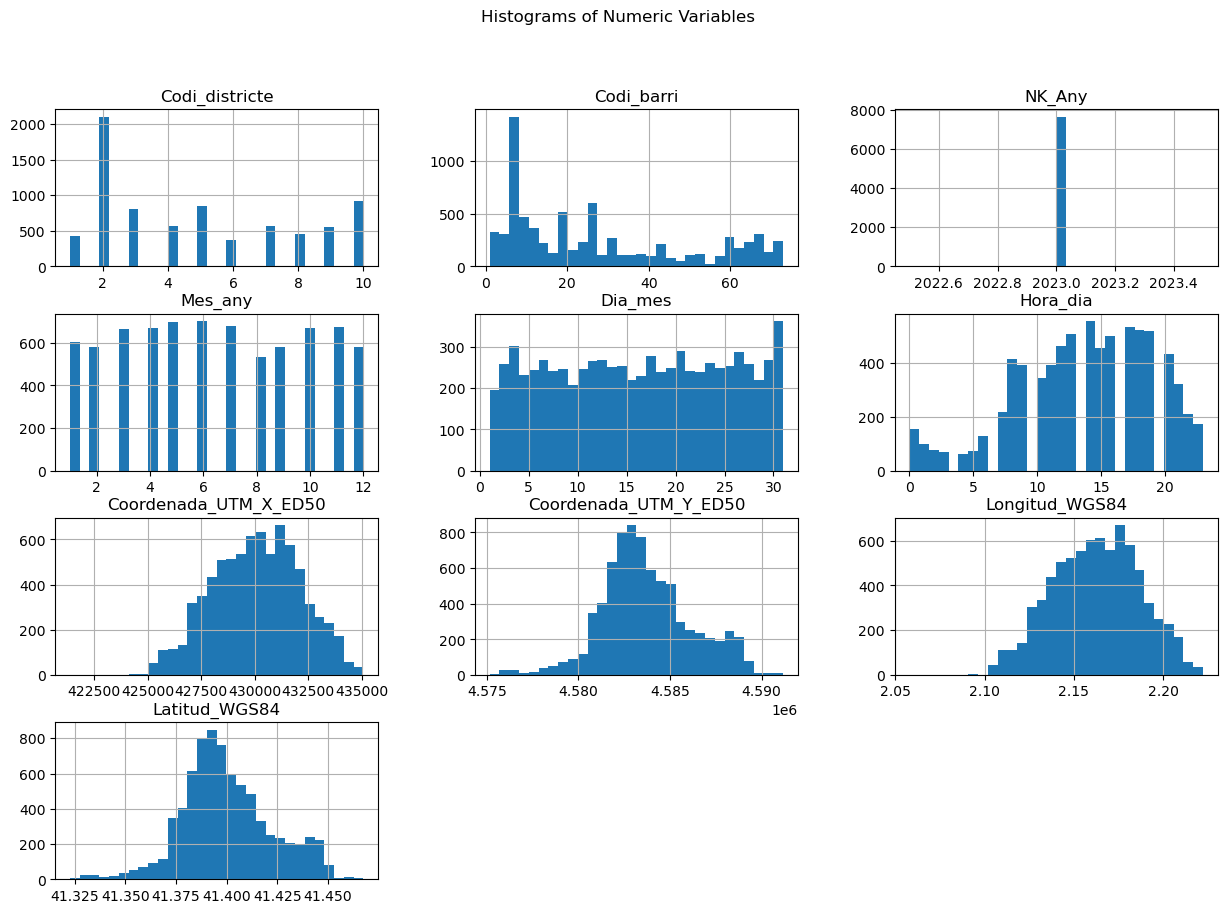

In [91]:
eda.plot_histograms(data)

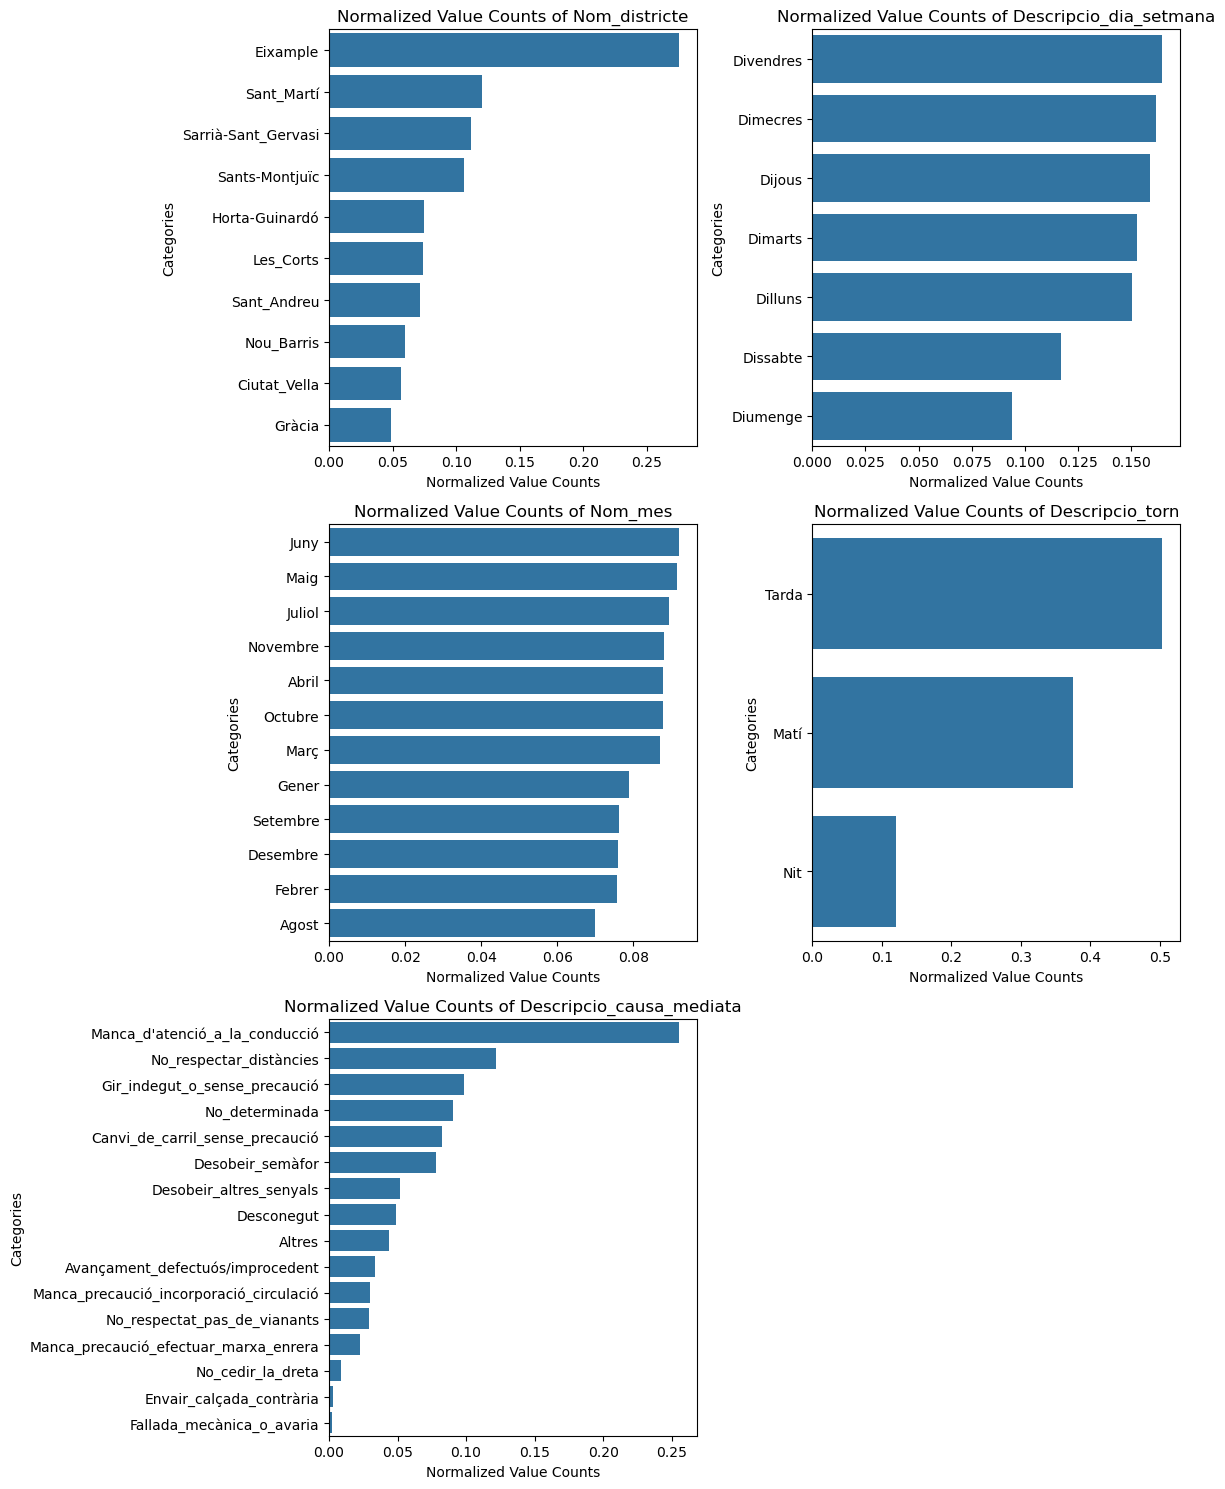

In [92]:
eda.plot_barplots_normalized(data, exclude=['Numero_expedient', 'Nom_barri', 'Nom_carrer', 'Num_postal'])

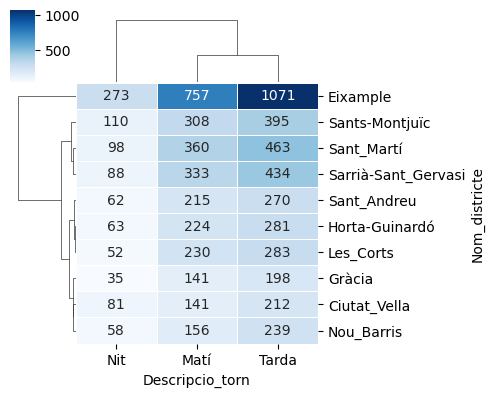

In [93]:
# Count the number of events per district and shift
pivot_data_district_shift = data.groupby(['Nom_districte', 'Descripcio_torn']).size().unstack().fillna(0)

# Generate a clustermap with hierarchical clustering
sns.clustermap(pivot_data_district_shift, cmap="Blues", linewidths=0.5, annot=True, fmt='g', figsize=(5,4))

# Show the plot
plt.show()


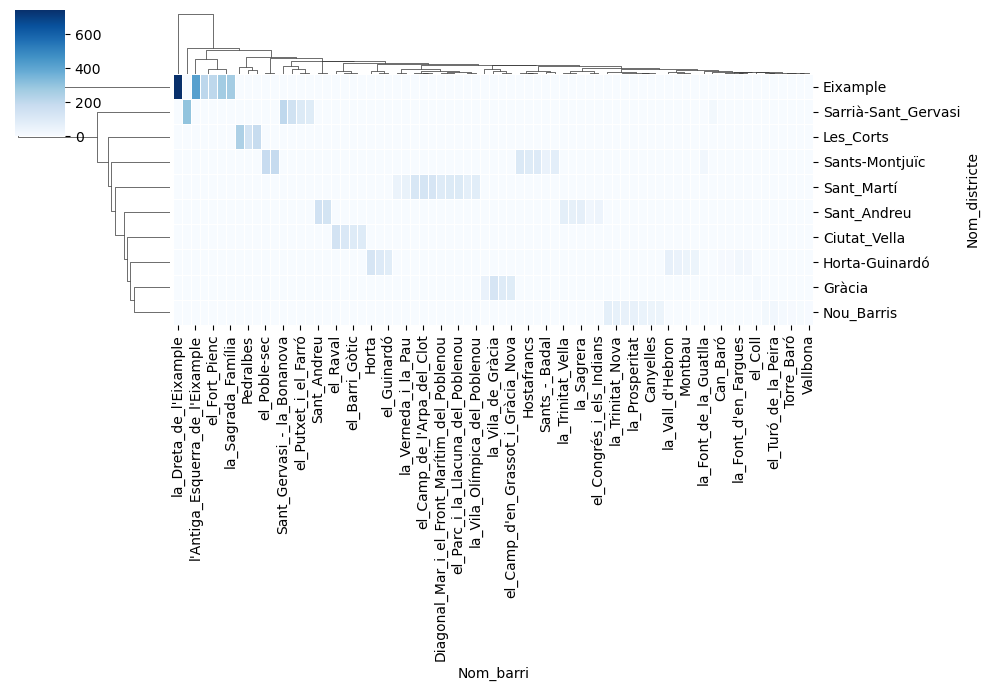

In [94]:
# Count the number of events per district and neighborhood

pivot_data_district_neighborhood = data.groupby(['Nom_districte', 'Nom_barri']).size().unstack().fillna(0)

# Generate a clustermap with hierarchical clustering
sns.clustermap(pivot_data_district_neighborhood, cmap="Blues", linewidths=0.5, figsize=(10,7))

# Show the plot
plt.show()

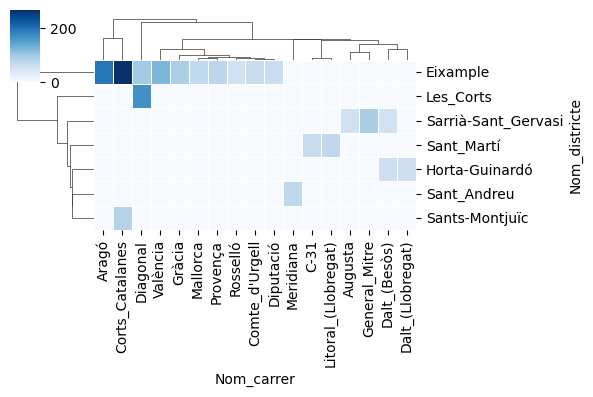

In [95]:
# Count the number of events per district and street (only high ocurrence streets)
threshold = 50

pivot_data_neighborhood_street = data.groupby(['Nom_districte', 'Nom_carrer']).size().unstack().fillna(0)
pivot_data_filtered = pivot_data_neighborhood_street[pivot_data_neighborhood_street > threshold]
pivot_data_filtered = pivot_data_filtered.fillna(0)

# Ensure rows and columns with all zeros are removed (optional, for cleaner visualization)
pivot_data_filtered = pivot_data_filtered.loc[~(pivot_data_filtered == 0).all(axis=1), (pivot_data_filtered != 0).any(axis=0)]

# Generate a clustermap with hierarchical clustering
sns.clustermap(pivot_data_filtered, cmap="Blues", linewidths=0.5, figsize=(6,4))

# Show the plot
plt.show()

## Map view

In [96]:
# Load the districts GeoDataFrame --> Downloaded from https://opendata-ajuntament.barcelona.cat/data/ca/dataset/accidents_causa_conductor_gu_bcn/resource/5a040155-38b3-4b19-a4b0-c84a0618d363
districts = pd.read_csv("./data/BarcelonaCiutat_Districtes.csv")
districts['nom_districte'] = districts['nom_districte'].str.replace(' ', '_')
districts.head()

,Codi_Districte,nom_districte,geometria_etrs89,geometria_wgs84
0,1,Ciutat_Vella,"POLYGON ((431735.899600634 4582445.23444175, 4...","POLYGON ((2.18347683856251 41.390642940051, 2...."
1,2,Eixample,"POLYGON ((432035.336202865 4583668.43902139, 4...","POLYGON ((2.18692083199788 41.4016853455437, 2..."
2,3,Sants-Montjuïc,"POLYGON ((431601.608976907 4579536.03044858, 4...","POLYGON ((2.1821990169001 41.3644291256417, 2...."
3,4,Les_Corts,"POLYGON ((425056.8965533 4583675.91596755, 425...","POLYGON ((2.10344434732743 41.401132502692, 2...."
4,5,Sarrià-Sant_Gervasi,"POLYGON ((422050.616047581 4586562.54207296, 4...","POLYGON ((2.06711232318739 41.4268447598344, 2..."


In [97]:
unmatched_districts = []

# Loop to check if any district in data is missing in districts
for dist in data.Nom_districte.unique():
    if dist not in districts.nom_districte.to_list():
        unmatched_districts.append(dist)

# Check if all districts matched
if unmatched_districts:
    for dist in unmatched_districts:
        print(f"District not found: {dist}")
else:
    print("All districts match")

All districts match


### Barcelona heatmap showing density of accidents in 2023
High concentration in Eixample

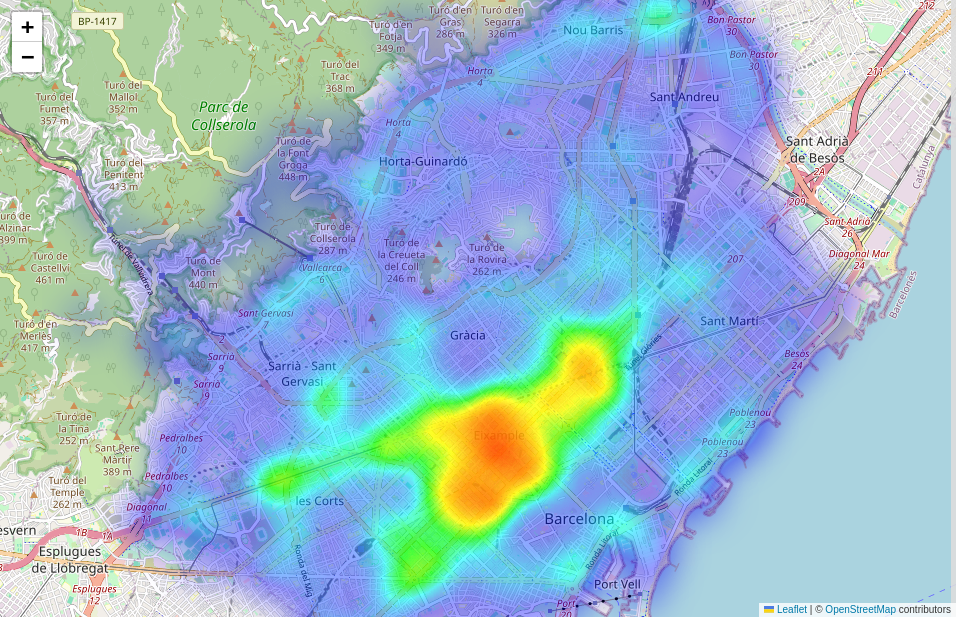

Check out interactive HTML map at: ./viz/barcelona_heatmap.html
PNG image saved to: ./viz/barcelona_heatmap.png


In [98]:
# Prepare the data for the heatmap
heat_data = [[row['Latitud_WGS84'], row['Longitud_WGS84']] for index, row in data.iterrows()]

# Create a folium map centered on Barcelona
m = folium.Map(location=[41.41, 2.16], zoom_start=12.5, )
# Add the heatmap layer
HeatMap(heat_data, blur=30, min_opacity=0.2).add_to(m)

eda.render_folium_map(m, "./viz/barcelona_heatmap.html", "./viz/barcelona_heatmap.png")

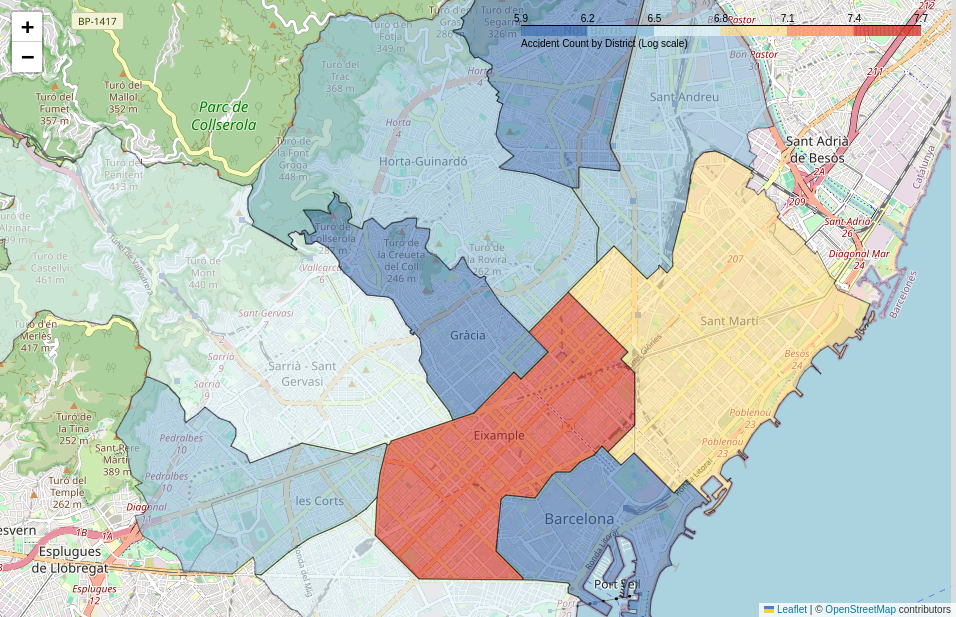

Check out interactive HTML map at: ./viz/barcelona_districts_event_map.html
PNG image saved to: ./viz/barcelona_districts_event_map.png


In [99]:
# Convert the WKT geometries (from 'geometria_wgs84') to Shapely objects
districts['geometry'] = districts['geometria_wgs84'].apply(wkt.loads)

# Create a GeoDataFrame from the CSV file, setting CRS to WGS84
districts = gpd.GeoDataFrame(districts, geometry='geometry', crs='epsg:4326')

# Count the number of events per district
event_counts = data.groupby('Nom_districte').size().reset_index(name='event_count')

# Merge the event counts with the districts GeoDataFrame
districts = districts.merge(event_counts, left_on='nom_districte', right_on='Nom_districte', how='left')
districts['event_count'] = np.log(districts['event_count'])

# Create a folium map centered on Barcelona
m = folium.Map(location=[41.41, 2.16], zoom_start=12.5)

# Add Choropleth to the map
folium.Choropleth(
    geo_data=districts.__geo_interface__,  # Convert GeoDataFrame to GeoJSON format
    name='choropleth',
    data=districts,
    columns=['nom_districte', 'event_count'],  # Data for choropleth
    key_on='feature.properties.nom_districte',  # Key to match districts by name
    fill_color='RdYlBu_r', 
    fill_opacity=0.6,
    line_opacity=0.5,
    legend_name='Accident Count by District (Log scale)'
).add_to(m)

# Save and display the map
eda.render_folium_map(m, "./viz/barcelona_districts_event_map.html", "./viz/barcelona_districts_event_map.png")

# Exploratory Analysis: Final Insights

- The district with the highest accident rates is **Eixample**, with accidents peaking during the **afternoon** and **night** shifts.
- Other districts with significant accident occurrences include **Sant Martí** and **Sarrià**.
- The neighborhoods with the highest accident frequencies are **La Dreta de l'Eixample** and **Fort Pienc**.
- Among the most accident-prone streets in Barcelona are **Carrer d'Aragó**, **Gran Via de les Corts Catalanes**, and **Avinguda Diagonal**.
- These patterns are evident in both the exploratory heatmaps and interactive Folium maps. For more detailed street-level insights, refer to the HTML file where you can zoom in on specific streets.

# Creating the Forecasting Target

## Motivation
Given the open-ended nature of the dataset, I chose to approach it as a time-series forecasting problem. I believe this is the most useful data-driven decision-making output for predictive modeling, as forecasting the number of accidents per district and shift allows for actionable insights. Specifically, it enables security forces to allocate resources efficiently based on anticipated accident counts, improving both operational planning and public safety.

- **Unique Identifier**: Combined `Descripcio_torn` (Shift Description) and `Nom_districte` (District Name) to create `unique_id` for each district-shift pair.
- **Date Column**: Constructed a date column by merging year (`NK_Any`), month (`Mes_any`), and day (`Dia_mes`) features.
- **Target Variable**: Aggregated the number of accidents per day for each `unique_id` to establish the daily accident count as the forecasting target.

## Objective
To predict the daily number of traffic accidents for each district-shift combination. This prediction aims to optimize resource allocation for security forces by forecasting accident rates, thus enhancing public safety and operational efficiency.

## Approach and Rationale
Given the dataset is limited to only the year 2023, the analysis focuses on the district and shift level of granularity (`Descripcio_torn` + `Nom_districte`). This aggregation ensures sufficient data for each `unique_id` while capturing meaningful temporal and spatial patterns.

## Future Enhancements:
- **Increased Granularity**: With additional historical data, the model can be refined to include more detailed time intervals (e.g., street-level and hourly accident counts).
- **Incorporating More Features**: Future datasets could integrate detailed temporal features (e.g., specific hours, weather conditions) to further improve predictive accuracy.


Preparing data:

In [28]:
# All the steps above were done step by step to document the process
# Here we combine them in one function

def data_processing(data):
    
    eda = InitialEDA()
    
    # Strip column names
    data.columns = data.columns.str.strip()
    
    # Get categorical columns
    cat_cols = eda.get_categorical(data)
    
    # Clean and replace spaces in each categorical column
    for col in cat_cols:
        if data[col].isnull().any():
            data[col] = data[col].fillna('')  # Fill NaNs with an empty string
        data[col] = data[col].str.strip()          # Remove leading/trailing whitespace
        data[col] = data[col].str.replace(' ', '_')  # Replace spaces with underscores
    
    # Remove specific duplicates
    data = data[~((data['Descripcio_causa_mediata'] == 'Altres') & 
                  data.duplicated(subset=['Numero_expedient'], keep=False))]
    
    # Remove remaining duplicates
    data = data.drop_duplicates(subset=['Numero_expedient'], keep='first')
    
    # Remove rows with 'Desconegut' in 'Nom_districte'
    data = data[data['Nom_districte'] != 'Desconegut']
    
    # Delete 'Codi_carrer' column
    del data['Codi_carrer']

    return data

data = pd.read_csv("./data/2023_accidents_causa_conductor_gu_bcn_.csv")
data = data_processing(data)

print("Number of rows:", data.shape[0])

Number of rows: 7631


In [29]:
data['unique_id'] = data['Descripcio_torn'].astype(str) + '-' + data['Nom_districte'].astype(str)
print("Number of unique_id:", data['unique_id'].nunique())

data['date'] = data.apply(lambda row: datetime.datetime(year=row['NK_Any'], 
                                                        month=row['Mes_any'], 
                                                        day=row['Dia_mes']), axis=1)

print("Expected number of rows:", data['unique_id'].nunique()*365)
print("Actual number of rows:", data.shape[0])

Number of unique_id: 30
Expected number of rows: 10950
Actual number of rows: 7631


Target creation:

(10950, 3)


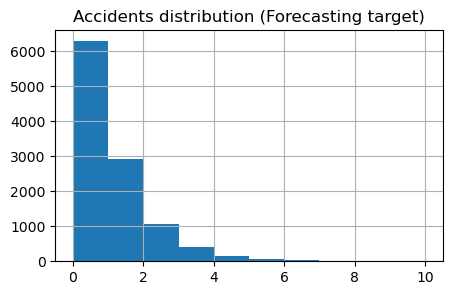

In [30]:
# Create the Date Range
all_dates = pd.date_range(start="2023-01-01", end="2023-12-31")

# Extract Unique Identifiers
unique_ids = data['unique_id'].unique()

# Create a Cartesian Product of `unique_id` and Dates
all_combinations = pd.MultiIndex.from_product(
    [unique_ids, all_dates],
    names=['unique_id', 'date']
).to_frame(index=False)

# Aggregate Accident Counts
daily_counts = (
    data
    .groupby(['unique_id', 'date'])
    .size()
    .reset_index(name='accident_count')
)

# Merge to Ensure All Combinations are Present
complete_daily_counts = all_combinations.merge(
    daily_counts,
    on=['unique_id', 'date'],
    how='left'
)

# Fill Missing Accident Counts with Zero
complete_daily_counts['accident_count'] = complete_daily_counts['accident_count'].fillna(0)

# Optional: Visualize the Distribution
print(complete_daily_counts.shape)
complete_daily_counts['accident_count'].hist(figsize=(5, 3))
plt.title('Accidents distribution (Forecasting target)')
plt.show()

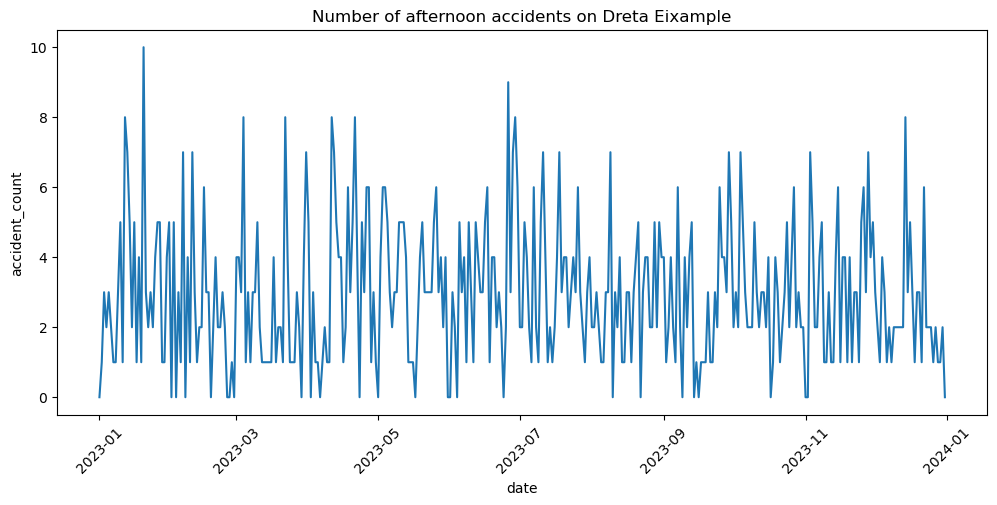

In [31]:
plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='accident_count', data=complete_daily_counts.query('unique_id == "Tarda-Eixample"')) #Dreta Eixample = 2-7
plt.title('Number of afternoon accidents on Dreta Eixample')
plt.xticks(rotation=45)
plt.show()

# Feature Engineering

In [32]:
fe = FeatureEngineering()

# Recreate Initial Features
df, cat_cols, feature_cols = fe.recreate_features(complete_daily_counts)
print(f"Initial DataFrame shape: {df.shape}")

# Create aditional features
df, new_features = fe.add_aditional_features(df)

# Create target lag features
df = fe.ML_forecast_target_lags(df, 'unique_id', 'date', 'accident_count')

lag_features = [
               'lag1',
               'lag2', 'lag7', 'lag30', 'rolling_mean_lag1_window_size3',
               'rolling_std_lag1_window_size3', 'rolling_mean_lag1_window_size7',
               'rolling_std_lag1_window_size7', 'rolling_mean_lag1_window_size30',
               'rolling_std_lag1_window_size30',
               'exponentially_weighted_mean_lag1_alpha0.5',
               'exponentially_weighted_mean_lag1_alpha0.8',
               'rolling_mean_lag2_window_size3', 'rolling_std_lag2_window_size3',
               'rolling_mean_lag2_window_size7', 'rolling_std_lag2_window_size7',
               'rolling_mean_lag2_window_size30', 'rolling_std_lag2_window_size30',
               'rolling_mean_lag7_window_size3', 'rolling_mean_lag30_window_size3'
            ]

# Fill NaNs with the mean of each unique_id
df[lag_features] = df.groupby('unique_id')[lag_features].transform(lambda x: x.fillna(x.median()))

# Create grouped lag features
groups = [
    ['shift'],
    ['district'],
    ['namedayweek'],
    ['shift', 'namedayweek'],
    ['district', 'namedayweek'],
    ['shift', 'month'],
    ['district', 'month'],
]
agg_functions = ['sum', 'max', 'min', 'mean']

all_new_columns = []

for group in groups:
    for agg_func in agg_functions:
        df, new_group_cols = fe.build_group_features(
            df=df,
            cols_to_group=group,
            target_column='accident_count',
            aggfunc=agg_func,
            lags=[1, 7],
        )
        # Extend the list with new columns from each function call
        all_new_columns.extend(new_group_cols)

print(f"Initial DataFrame shape: {df.shape}")

Initial DataFrame shape: (10950, 10)
Dropping columns that might cause target leakage shift_accident_count_sum
Dropping columns that might cause target leakage shift_accident_count_max
Dropping columns that might cause target leakage shift_accident_count_min
Dropping columns that might cause target leakage shift_accident_count_mean
Dropping columns that might cause target leakage district_accident_count_sum
Dropping columns that might cause target leakage district_accident_count_max
Dropping columns that might cause target leakage district_accident_count_min
Dropping columns that might cause target leakage district_accident_count_mean
Dropping columns that might cause target leakage namedayweek_accident_count_sum
Dropping columns that might cause target leakage namedayweek_accident_count_max
Dropping columns that might cause target leakage namedayweek_accident_count_min
Dropping columns that might cause target leakage namedayweek_accident_count_mean
Dropping columns that might cause ta

In [33]:
# Extend features list
feature_cols += new_features
feature_cols += lag_features
feature_cols += all_new_columns


print("Number of final features:", len(feature_cols))
print("Number of categorical features:", len(cat_cols))
print("Number of missing values:", df.isna().sum().sum())

Number of final features: 89
Number of categorical features: 3
Number of missing values: 126660


# Train and predict future accident count per district and shift

## Train, valid, test split

In [34]:
df_sorted = df.sort_values(by=['unique_id', 'date']).set_index('unique_id')

# Get the sorted list of unique dates
unique_dates = sorted(df["date"].unique())

# Define train, validation, and test indices based on dates
train_dates = unique_dates[:-20]  # Train on all except the last 20 days
val_dates = unique_dates[-20:-10]   # Validation on days -20 to -10
test_dates = unique_dates[-10:]  # Test on the last 10 days

train = df_sorted[df_sorted['date'].isin(train_dates)]
valid = df_sorted[df_sorted['date'].isin(val_dates)]
test = df_sorted[df_sorted['date'].isin(test_dates)]

X_train, y_train = train[feature_cols], train['accident_count']
X_valid, y_valid = valid[feature_cols], valid['accident_count']
X_test, y_test = test[feature_cols], test['accident_count']

## LightGBM

In [35]:
lgb_params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'mae',
    'random_state': 23,
    'verbosity': -1
}

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 0.673275


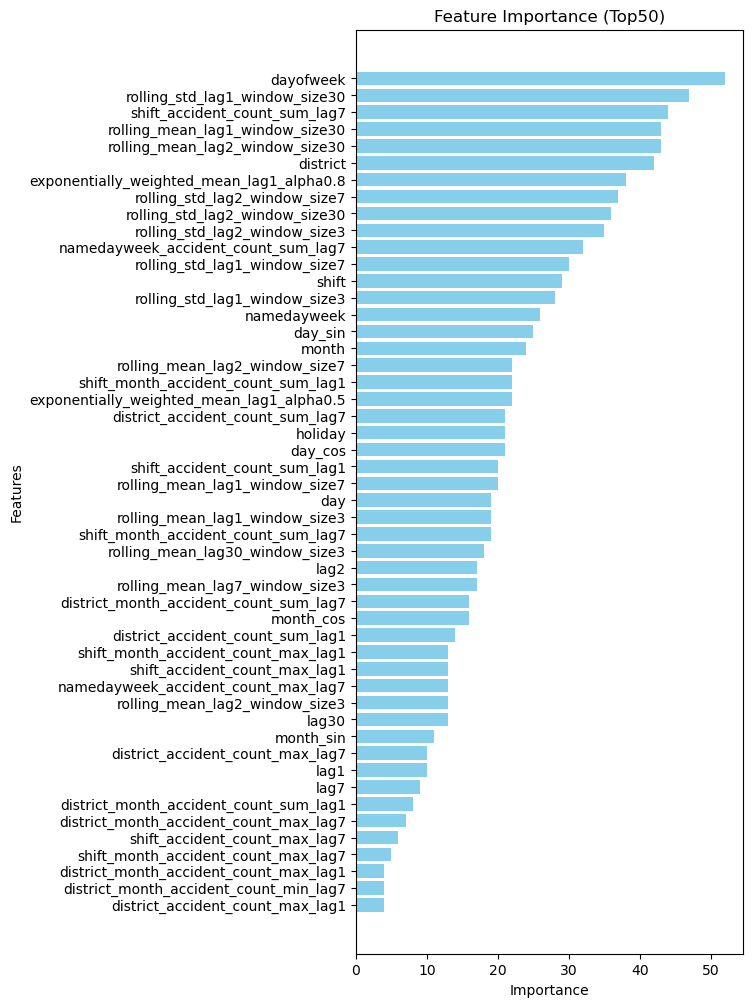


Train MAE: 0.5791

Validation MAE: 0.6733

Test MAE: 0.5788


In [36]:
lgb_model = lgb.LGBMRegressor(**lgb_params)

# Train the model with validation set for early stopping
lgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(10)])

# Predict on train set to assess model overfitting
y_train_pred = lgb_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Feature importance
importance = lgb_model.feature_importances_

def plot_feature_importance(importance, feature_cols):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values(by='importance', ascending=False).head(50)

    # Plot feature importance as a horizontal bar plot
    plt.figure(figsize=(5, 12))
    plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance (Top50)')
    plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature on top
    plt.show()
plot_feature_importance(importance, feature_cols)

# Predict on validation set and calculate MAE
y_valid_pred = lgb_model.predict(X_valid)
valid_mae = mean_absolute_error(y_valid, y_valid_pred)
print(f"\nTrain MAE: {train_mae:.4f}")
print(f"\nValidation MAE: {valid_mae:.4f}")

# Predict on test set and calculate MAE on test set
y_test_pred = lgb_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"\nTest MAE: {test_mae:.4f}")

# ----------------- CV BENCHMARK -------------------
# Initial features: Validation MAE: 0.6600, Test MAE: 0.6119

## CatBoost

In [37]:
cb_params = {
    'eval_metric': 'MAE',
    'cat_features': cat_cols,
    'verbose': 0,
    'early_stopping_rounds': 10,
    'random_state': 23
}

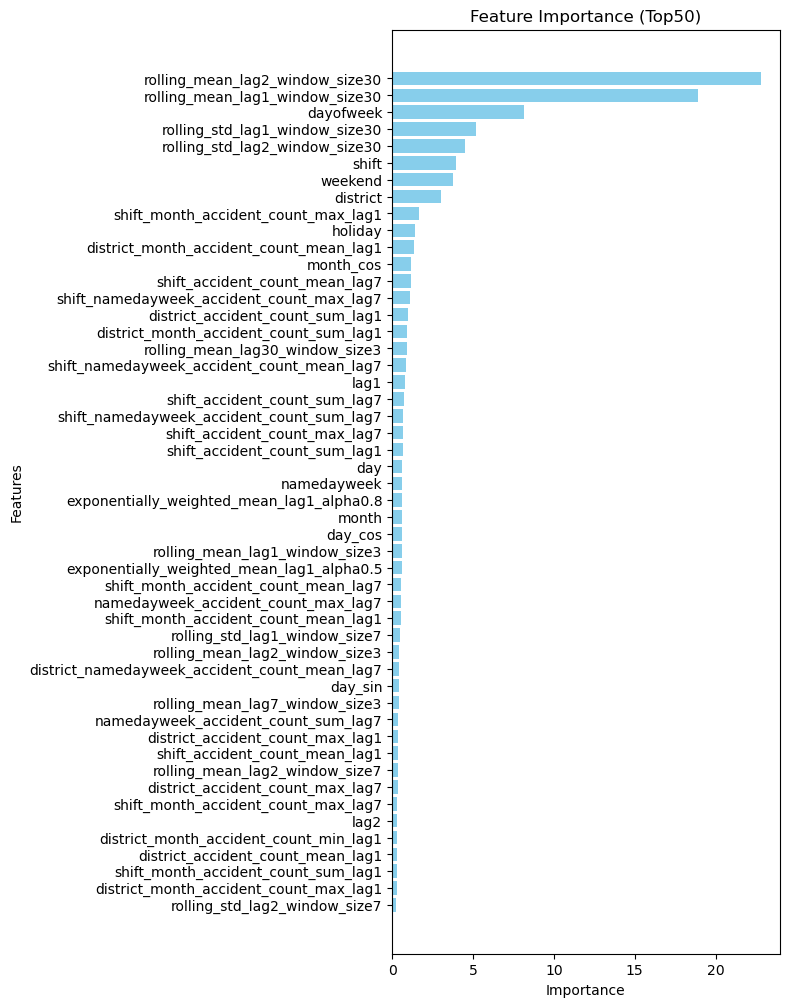


Train MAE: 0.6229

Validation MAE: 0.6680

Test MAE: 0.5625


In [38]:
# Initialize the CatBoostRegressor
cb_model = CatBoostRegressor(**cb_params)

# Train the model using the train set and validate on the validation set
cb_model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)

# Predict on train set to assess model overfitting
y_train_pred = cb_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Feature importance
importance = cb_model.get_feature_importance()
plot_feature_importance(importance, feature_cols)

# Predict on validation set and calculate MAE
y_valid_pred = cb_model.predict(X_valid)
valid_mae = mean_absolute_error(y_valid, y_valid_pred)
print(f"\nTrain MAE: {train_mae:.4f}")
print(f"\nValidation MAE: {valid_mae:.4f}")

# Predict on test set and calculate MAE on test set
y_test_pred = cb_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"\nTest MAE: {test_mae:.4f}")

# ----------------- CV BENCHMARK -------------------
# Initial features: Validation MAE: 0.6484, Test MAE: 0.5982

## Final ensemble for prediction

In [39]:
# Predict with the individual models
lgb_preds = lgb_model.predict(X_test)
cb_preds = cb_model.predict(X_test)

# weighted mean of the predictions
mean_preds = (lgb_preds * 0.5 + cb_preds * 0.5)
mean_mae = mean_absolute_error(y_test, mean_preds)
print(f"FINAL MAE (Mean of Predictions on Test Set): {mean_mae:.4f}")

FINAL MAE (Mean of Predictions on Test Set): 0.5692


# Hyperparameter tunning

In [14]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    # Hyperparameter spaces for LightGBM
    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'mae',
        'random_state': 23,
        'verbosity': -1,
        'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('lgb_learning_rate', 1e-4, 1e-1, log=True),
        'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 150),
        'max_depth': trial.suggest_int('lgb_max_depth', 3, 15),
    }
    
    # Hyperparameter spaces for CatBoost
    cb_params = {
        'eval_metric': 'MAE',
        'cat_features': cat_cols,
        'verbose': 0,
        'early_stopping_rounds': 10,
        'random_state': 23,
        'iterations': trial.suggest_int('cb_iterations', 100, 1000),
        'learning_rate': trial.suggest_float('cb_learning_rate', 1e-4, 1e-1, log=True),
        'depth': trial.suggest_int('cb_depth', 3, 15),
        'l2_leaf_reg': trial.suggest_float('cb_l2_leaf_reg', 1e-3, 10, log=True),
    }

    # Train LightGBM model
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(X_train, y_train, 
                  eval_set=[(X_valid, y_valid)], 
                  callbacks=[lgb.early_stopping(10)])
    
    # Predict with LightGBM model
    lgb_preds_test = lgb_model.predict(X_test)
    lgb_test_mae = mean_absolute_error(y_test, lgb_preds_test)
    
    # Train CatBoost model
    cb_model = CatBoostRegressor(**cb_params)
    cb_model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        use_best_model=True
    )
    
    # Predict with CatBoost model
    cb_preds_test = cb_model.predict(X_test)
    cb_test_mae = mean_absolute_error(y_test, cb_preds_test)
    
    # # Suggest weights for the ensemble
    # lgb_weight = trial.suggest_float('lgb_weight', 0.0, 1.0)
    # cb_weight = trial.suggest_float('cb_weight', 0.0, 1.0)
    
    # # Normalize weights to sum to 1
    # total_weight = lgb_weight + cb_weight
    # if total_weight == 0:
    #     lgb_weight = 0.5
    #     cb_weight = 0.5
    # else:
    #     lgb_weight /= total_weight
    #     cb_weight /= total_weight

    # Weights could be also optimized
    lgb_weight = 0.5
    cb_weight = 0.5
    
    # Compute weighted predictions
    ensemble_preds = lgb_preds_test * lgb_weight + cb_preds_test * cb_weight
    ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
    print("*************************************************************")
    print(f"FINAL MAE (Weighted Mean of Predictions on Test Set): {ensemble_mae:.4f}")
    print("*************************************************************")

    # Log individual MAEs for analysis (optional)
    trial.set_user_attr('lgb_test_mae', lgb_test_mae)
    trial.set_user_attr('cb_test_mae', cb_test_mae)
    trial.set_user_attr('ensemble_mae', ensemble_mae)
    
    # Return the ensemble MAE as the objective value to be minimized
    return ensemble_mae

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-10-07 14:02:23,394] A new study created in memory with name: no-name-de48511b-b748-4ae7-9e54-74f14abb22a6


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[752]	valid_0's l1: 0.68498


[I 2024-10-07 14:02:33,173] Trial 0 finished with value: 0.5837282010219049 and parameters: {'lgb_n_estimators': 752, 'lgb_learning_rate': 0.0020723435776487486, 'lgb_num_leaves': 49, 'lgb_max_depth': 10, 'cb_iterations': 236, 'cb_learning_rate': 0.0317891588865283, 'cb_depth': 11, 'cb_l2_leaf_reg': 0.014745505705710073}. Best is trial 0 with value: 0.5837282010219049.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5837
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[553]	valid_0's l1: 0.675626


[I 2024-10-07 14:02:36,531] Trial 1 finished with value: 0.5756479028496904 and parameters: {'lgb_n_estimators': 559, 'lgb_learning_rate': 0.004056579067081472, 'lgb_num_leaves': 73, 'lgb_max_depth': 9, 'cb_iterations': 356, 'cb_learning_rate': 0.015598849566259707, 'cb_depth': 5, 'cb_l2_leaf_reg': 0.03677672086216041}. Best is trial 1 with value: 0.5756479028496904.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5756
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[589]	valid_0's l1: 0.697854


[I 2024-10-07 14:02:38,939] Trial 2 finished with value: 0.626796596967681 and parameters: {'lgb_n_estimators': 589, 'lgb_learning_rate': 0.0017583620643207801, 'lgb_num_leaves': 88, 'lgb_max_depth': 6, 'cb_iterations': 195, 'cb_learning_rate': 0.0013409875653202002, 'cb_depth': 7, 'cb_l2_leaf_reg': 3.835532878929233}. Best is trial 1 with value: 0.5756479028496904.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.6268
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[240]	valid_0's l1: 0.743637


[I 2024-10-07 14:04:25,087] Trial 3 finished with value: 0.6485966102929713 and parameters: {'lgb_n_estimators': 240, 'lgb_learning_rate': 0.0022592125312525494, 'lgb_num_leaves': 92, 'lgb_max_depth': 10, 'cb_iterations': 146, 'cb_learning_rate': 0.0012307301893119112, 'cb_depth': 15, 'cb_l2_leaf_reg': 0.001517996980674454}. Best is trial 1 with value: 0.5756479028496904.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.6486
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 0.683144


[I 2024-10-07 14:08:50,947] Trial 4 finished with value: 0.5845499922375569 and parameters: {'lgb_n_estimators': 308, 'lgb_learning_rate': 0.02118773875046362, 'lgb_num_leaves': 135, 'lgb_max_depth': 14, 'cb_iterations': 407, 'cb_learning_rate': 0.009679993055889662, 'cb_depth': 15, 'cb_l2_leaf_reg': 9.4837444532449}. Best is trial 1 with value: 0.5756479028496904.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5845
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[258]	valid_0's l1: 0.776488


[I 2024-10-07 14:08:55,386] Trial 5 finished with value: 0.6586535442248906 and parameters: {'lgb_n_estimators': 258, 'lgb_learning_rate': 0.0012688497293575, 'lgb_num_leaves': 96, 'lgb_max_depth': 12, 'cb_iterations': 886, 'cb_learning_rate': 0.0001863004292402315, 'cb_depth': 4, 'cb_l2_leaf_reg': 0.01915351159854195}. Best is trial 1 with value: 0.5756479028496904.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.6587
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[642]	valid_0's l1: 0.677683


[I 2024-10-07 14:08:58,705] Trial 6 finished with value: 0.5857581117790592 and parameters: {'lgb_n_estimators': 643, 'lgb_learning_rate': 0.0027912023211938476, 'lgb_num_leaves': 116, 'lgb_max_depth': 12, 'cb_iterations': 559, 'cb_learning_rate': 0.05463380511483882, 'cb_depth': 8, 'cb_l2_leaf_reg': 0.016824326406462815}. Best is trial 1 with value: 0.5756479028496904.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5858
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[589]	valid_0's l1: 0.791247


[I 2024-10-07 14:09:05,501] Trial 7 finished with value: 0.6460133450196532 and parameters: {'lgb_n_estimators': 589, 'lgb_learning_rate': 0.0004289907680056269, 'lgb_num_leaves': 102, 'lgb_max_depth': 14, 'cb_iterations': 775, 'cb_learning_rate': 0.0006238341875051037, 'cb_depth': 7, 'cb_l2_leaf_reg': 0.10169681956807297}. Best is trial 1 with value: 0.5756479028496904.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.6460
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[969]	valid_0's l1: 0.804793


[I 2024-10-07 14:10:36,399] Trial 8 finished with value: 0.6590723746283209 and parameters: {'lgb_n_estimators': 969, 'lgb_learning_rate': 0.00019499350346008267, 'lgb_num_leaves': 80, 'lgb_max_depth': 5, 'cb_iterations': 594, 'cb_learning_rate': 0.0004206939337391517, 'cb_depth': 13, 'cb_l2_leaf_reg': 0.009216663010125806}. Best is trial 1 with value: 0.5756479028496904.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.6591
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's l1: 0.819712


[I 2024-10-07 14:10:39,306] Trial 9 finished with value: 0.6359306499604895 and parameters: {'lgb_n_estimators': 192, 'lgb_learning_rate': 0.0006579569459177132, 'lgb_num_leaves': 102, 'lgb_max_depth': 5, 'cb_iterations': 333, 'cb_learning_rate': 0.002967458455278965, 'cb_depth': 6, 'cb_l2_leaf_reg': 0.13533691278403806}. Best is trial 1 with value: 0.5756479028496904.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.6359
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's l1: 0.675904


[I 2024-10-07 14:10:41,200] Trial 10 finished with value: 0.5760696695885315 and parameters: {'lgb_n_estimators': 410, 'lgb_learning_rate': 0.01761715199225357, 'lgb_num_leaves': 28, 'lgb_max_depth': 8, 'cb_iterations': 432, 'cb_learning_rate': 0.01212280574616718, 'cb_depth': 3, 'cb_l2_leaf_reg': 0.49973135618252185}. Best is trial 1 with value: 0.5756479028496904.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5761
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[129]	valid_0's l1: 0.671893


[I 2024-10-07 14:10:43,637] Trial 11 finished with value: 0.5746419395843122 and parameters: {'lgb_n_estimators': 397, 'lgb_learning_rate': 0.02324562358560688, 'lgb_num_leaves': 21, 'lgb_max_depth': 8, 'cb_iterations': 433, 'cb_learning_rate': 0.012167875195914765, 'cb_depth': 3, 'cb_l2_leaf_reg': 0.6985241669163569}. Best is trial 11 with value: 0.5746419395843122.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5746
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 0.663497


[I 2024-10-07 14:10:46,083] Trial 12 finished with value: 0.583166117157421 and parameters: {'lgb_n_estimators': 404, 'lgb_learning_rate': 0.09903832421814986, 'lgb_num_leaves': 59, 'lgb_max_depth': 8, 'cb_iterations': 674, 'cb_learning_rate': 0.012429811867669123, 'cb_depth': 5, 'cb_l2_leaf_reg': 0.7923403142881961}. Best is trial 11 with value: 0.5746419395843122.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5832
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[409]	valid_0's l1: 0.673737


[I 2024-10-07 14:10:47,001] Trial 13 finished with value: 0.5679875441415547 and parameters: {'lgb_n_estimators': 435, 'lgb_learning_rate': 0.008933622109172432, 'lgb_num_leaves': 21, 'lgb_max_depth': 7, 'cb_iterations': 424, 'cb_learning_rate': 0.0950814107152285, 'cb_depth': 3, 'cb_l2_leaf_reg': 0.6655902339818434}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5680
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[351]	valid_0's l1: 0.67111


[I 2024-10-07 14:10:47,830] Trial 14 finished with value: 0.5688567688013881 and parameters: {'lgb_n_estimators': 415, 'lgb_learning_rate': 0.010063834082720637, 'lgb_num_leaves': 21, 'lgb_max_depth': 7, 'cb_iterations': 482, 'cb_learning_rate': 0.08640058662406178, 'cb_depth': 3, 'cb_l2_leaf_reg': 0.8596330873093411}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5689
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[113]	valid_0's l1: 0.717606


[I 2024-10-07 14:10:49,535] Trial 15 finished with value: 0.5918646395942327 and parameters: {'lgb_n_estimators': 113, 'lgb_learning_rate': 0.007601170981317611, 'lgb_num_leaves': 41, 'lgb_max_depth': 3, 'cb_iterations': 998, 'cb_learning_rate': 0.07838004504512706, 'cb_depth': 9, 'cb_l2_leaf_reg': 2.1410192024685326}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5919
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 0.671604


[I 2024-10-07 14:10:51,824] Trial 16 finished with value: 0.575773576991409 and parameters: {'lgb_n_estimators': 808, 'lgb_learning_rate': 0.06935741105326382, 'lgb_num_leaves': 33, 'lgb_max_depth': 3, 'cb_iterations': 678, 'cb_learning_rate': 0.09586072812078367, 'cb_depth': 11, 'cb_l2_leaf_reg': 0.2799414639212314}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5758
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[357]	valid_0's l1: 0.665666


[I 2024-10-07 14:10:52,944] Trial 17 finished with value: 0.5739122237665654 and parameters: {'lgb_n_estimators': 482, 'lgb_learning_rate': 0.007909241112728503, 'lgb_num_leaves': 61, 'lgb_max_depth': 6, 'cb_iterations': 490, 'cb_learning_rate': 0.03518316584639246, 'cb_depth': 3, 'cb_l2_leaf_reg': 2.0672577855642666}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5739
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 0.672058


[I 2024-10-07 14:10:54,482] Trial 18 finished with value: 0.5874620721291984 and parameters: {'lgb_n_estimators': 475, 'lgb_learning_rate': 0.03998465815986878, 'lgb_num_leaves': 20, 'lgb_max_depth': 6, 'cb_iterations': 261, 'cb_learning_rate': 0.0044411722146287585, 'cb_depth': 5, 'cb_l2_leaf_reg': 0.27847134568863263}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5875
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[352]	valid_0's l1: 0.671113


[I 2024-10-07 14:11:00,109] Trial 19 finished with value: 0.5721902576644512 and parameters: {'lgb_n_estimators': 700, 'lgb_learning_rate': 0.008008700488456207, 'lgb_num_leaves': 45, 'lgb_max_depth': 7, 'cb_iterations': 655, 'cb_learning_rate': 0.03298509764979813, 'cb_depth': 10, 'cb_l2_leaf_reg': 1.5076090302381004}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5722
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[341]	valid_0's l1: 0.846229


[I 2024-10-07 14:11:03,073] Trial 20 finished with value: 0.6278024698598413 and parameters: {'lgb_n_estimators': 341, 'lgb_learning_rate': 0.00010215008870821973, 'lgb_num_leaves': 62, 'lgb_max_depth': 4, 'cb_iterations': 511, 'cb_learning_rate': 0.003708307537346298, 'cb_depth': 4, 'cb_l2_leaf_reg': 8.03106217624742}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.6278
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[301]	valid_0's l1: 0.670921


[I 2024-10-07 14:11:07,633] Trial 21 finished with value: 0.5764832391219278 and parameters: {'lgb_n_estimators': 701, 'lgb_learning_rate': 0.008215708960388366, 'lgb_num_leaves': 42, 'lgb_max_depth': 7, 'cb_iterations': 641, 'cb_learning_rate': 0.031382722636663106, 'cb_depth': 10, 'cb_l2_leaf_reg': 1.452431284340517}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5765
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[280]	valid_0's l1: 0.669939


[I 2024-10-07 14:11:19,166] Trial 22 finished with value: 0.5777871861207551 and parameters: {'lgb_n_estimators': 886, 'lgb_learning_rate': 0.011264990026631077, 'lgb_num_leaves': 34, 'lgb_max_depth': 7, 'cb_iterations': 778, 'cb_learning_rate': 0.053325534072885615, 'cb_depth': 12, 'cb_l2_leaf_reg': 3.9503798909532577}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5778
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[481]	valid_0's l1: 0.675555


[I 2024-10-07 14:11:23,968] Trial 23 finished with value: 0.5766945842651093 and parameters: {'lgb_n_estimators': 481, 'lgb_learning_rate': 0.004433958549434886, 'lgb_num_leaves': 51, 'lgb_max_depth': 9, 'cb_iterations': 308, 'cb_learning_rate': 0.022038059634247344, 'cb_depth': 9, 'cb_l2_leaf_reg': 0.24841963133136197}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5767
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's l1: 0.673105


[I 2024-10-07 14:11:33,590] Trial 24 finished with value: 0.5761993733661617 and parameters: {'lgb_n_estimators': 695, 'lgb_learning_rate': 0.03955525335128706, 'lgb_num_leaves': 20, 'lgb_max_depth': 7, 'cb_iterations': 740, 'cb_learning_rate': 0.0988273695770839, 'cb_depth': 13, 'cb_l2_leaf_reg': 1.0135720369669603}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5762
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[458]	valid_0's l1: 0.665647


[I 2024-10-07 14:11:35,342] Trial 25 finished with value: 0.5756005531554528 and parameters: {'lgb_n_estimators': 511, 'lgb_learning_rate': 0.005634683942787659, 'lgb_num_leaves': 38, 'lgb_max_depth': 5, 'cb_iterations': 520, 'cb_learning_rate': 0.053637908638590734, 'cb_depth': 7, 'cb_l2_leaf_reg': 0.42913503536980485}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5756
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[196]	valid_0's l1: 0.670455


[I 2024-10-07 14:11:45,411] Trial 26 finished with value: 0.5811998417048084 and parameters: {'lgb_n_estimators': 827, 'lgb_learning_rate': 0.013547282982795535, 'lgb_num_leaves': 49, 'lgb_max_depth': 11, 'cb_iterations': 617, 'cb_learning_rate': 0.0066601892004728245, 'cb_depth': 9, 'cb_l2_leaf_reg': 0.04655582488060244}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5812
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	valid_0's l1: 0.673296


[I 2024-10-07 14:11:46,933] Trial 27 finished with value: 0.5767112960911954 and parameters: {'lgb_n_estimators': 662, 'lgb_learning_rate': 0.04044953718111334, 'lgb_num_leaves': 28, 'lgb_max_depth': 9, 'cb_iterations': 455, 'cb_learning_rate': 0.022672093502710794, 'cb_depth': 4, 'cb_l2_leaf_reg': 3.703364787717323}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5767
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[202]	valid_0's l1: 0.667458


[I 2024-10-07 14:11:48,009] Trial 28 finished with value: 0.5701578591795025 and parameters: {'lgb_n_estimators': 361, 'lgb_learning_rate': 0.011386828987316595, 'lgb_num_leaves': 69, 'lgb_max_depth': 4, 'cb_iterations': 855, 'cb_learning_rate': 0.05717789390994213, 'cb_depth': 6, 'cb_l2_leaf_reg': 1.6042771291952014}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5702
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[341]	valid_0's l1: 0.759509


[I 2024-10-07 14:11:48,970] Trial 29 finished with value: 0.5930106670733569 and parameters: {'lgb_n_estimators': 341, 'lgb_learning_rate': 0.001269903236471872, 'lgb_num_leaves': 150, 'lgb_max_depth': 4, 'cb_iterations': 841, 'cb_learning_rate': 0.056589606649758616, 'cb_depth': 6, 'cb_l2_leaf_reg': 0.16559506923491432}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5930
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 0.665594


[I 2024-10-07 14:11:50,534] Trial 30 finished with value: 0.5738158758723911 and parameters: {'lgb_n_estimators': 144, 'lgb_learning_rate': 0.02752503937045828, 'lgb_num_leaves': 73, 'lgb_max_depth': 4, 'cb_iterations': 990, 'cb_learning_rate': 0.020902663565534607, 'cb_depth': 6, 'cb_l2_leaf_reg': 0.05408430484367001}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5738
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[242]	valid_0's l1: 0.671153


[I 2024-10-07 14:11:54,213] Trial 31 finished with value: 0.5726010488077564 and parameters: {'lgb_n_estimators': 405, 'lgb_learning_rate': 0.010461430462908409, 'lgb_num_leaves': 50, 'lgb_max_depth': 7, 'cb_iterations': 893, 'cb_learning_rate': 0.036425160952038745, 'cb_depth': 10, 'cb_l2_leaf_reg': 1.5013537873410907}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5726
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[536]	valid_0's l1: 0.667735


[I 2024-10-07 14:11:55,956] Trial 32 finished with value: 0.5719706663459565 and parameters: {'lgb_n_estimators': 536, 'lgb_learning_rate': 0.00452230987252604, 'lgb_num_leaves': 47, 'lgb_max_depth': 6, 'cb_iterations': 385, 'cb_learning_rate': 0.07253288547408604, 'cb_depth': 4, 'cb_l2_leaf_reg': 2.816929109298999}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5720
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[545]	valid_0's l1: 0.670057


[I 2024-10-07 14:11:57,870] Trial 33 finished with value: 0.5710981103924395 and parameters: {'lgb_n_estimators': 546, 'lgb_learning_rate': 0.003870915973734995, 'lgb_num_leaves': 73, 'lgb_max_depth': 6, 'cb_iterations': 391, 'cb_learning_rate': 0.06907848708681136, 'cb_depth': 4, 'cb_l2_leaf_reg': 5.5604822314379545}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5711
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[291]	valid_0's l1: 0.695164


[I 2024-10-07 14:11:58,887] Trial 34 finished with value: 0.5766395538531984 and parameters: {'lgb_n_estimators': 291, 'lgb_learning_rate': 0.0036547002404391823, 'lgb_num_leaves': 71, 'lgb_max_depth': 5, 'cb_iterations': 274, 'cb_learning_rate': 0.09810577764737324, 'cb_depth': 3, 'cb_l2_leaf_reg': 5.904872118351399}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5766
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[455]	valid_0's l1: 0.707903


[I 2024-10-07 14:12:00,570] Trial 35 finished with value: 0.5828545837957761 and parameters: {'lgb_n_estimators': 455, 'lgb_learning_rate': 0.0018711115658684564, 'lgb_num_leaves': 85, 'lgb_max_depth': 6, 'cb_iterations': 359, 'cb_learning_rate': 0.041192088394985775, 'cb_depth': 5, 'cb_l2_leaf_reg': 5.450300466329075}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5829
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 0.66748


[I 2024-10-07 14:12:01,574] Trial 36 finished with value: 0.5768513288625466 and parameters: {'lgb_n_estimators': 573, 'lgb_learning_rate': 0.017112906529089048, 'lgb_num_leaves': 115, 'lgb_max_depth': 4, 'cb_iterations': 183, 'cb_learning_rate': 0.019609359965668614, 'cb_depth': 4, 'cb_l2_leaf_reg': 0.9448425125327646}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5769
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[343]	valid_0's l1: 0.678881


[I 2024-10-07 14:12:03,154] Trial 37 finished with value: 0.5787432351400392 and parameters: {'lgb_n_estimators': 343, 'lgb_learning_rate': 0.005354778172267001, 'lgb_num_leaves': 69, 'lgb_max_depth': 10, 'cb_iterations': 550, 'cb_learning_rate': 0.06483462853498329, 'cb_depth': 3, 'cb_l2_leaf_reg': 0.0011770270954313833}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5787
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[209]	valid_0's l1: 0.751781


[I 2024-10-07 14:12:04,913] Trial 38 finished with value: 0.6576855563267192 and parameters: {'lgb_n_estimators': 209, 'lgb_learning_rate': 0.002651749568967224, 'lgb_num_leaves': 80, 'lgb_max_depth': 3, 'cb_iterations': 209, 'cb_learning_rate': 0.00010960967972012543, 'cb_depth': 5, 'cb_l2_leaf_reg': 0.002744945016788641}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.6577
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[219]	valid_0's l1: 0.670934


[I 2024-10-07 14:12:06,016] Trial 39 finished with value: 0.5981178551771472 and parameters: {'lgb_n_estimators': 600, 'lgb_learning_rate': 0.012891276443573008, 'lgb_num_leaves': 113, 'lgb_max_depth': 8, 'cb_iterations': 112, 'cb_learning_rate': 0.007102839503721811, 'cb_depth': 4, 'cb_l2_leaf_reg': 0.4103635640445339}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5981
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[283]	valid_0's l1: 0.759992


[I 2024-10-07 14:12:10,824] Trial 40 finished with value: 0.6377590873334755 and parameters: {'lgb_n_estimators': 283, 'lgb_learning_rate': 0.001530231306134675, 'lgb_num_leaves': 128, 'lgb_max_depth': 15, 'cb_iterations': 469, 'cb_learning_rate': 0.00110609479297563, 'cb_depth': 7, 'cb_l2_leaf_reg': 2.662527232403321}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.6378
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[532]	valid_0's l1: 0.673068


[I 2024-10-07 14:12:12,454] Trial 41 finished with value: 0.5756142551307467 and parameters: {'lgb_n_estimators': 532, 'lgb_learning_rate': 0.0036058106609719257, 'lgb_num_leaves': 56, 'lgb_max_depth': 6, 'cb_iterations': 380, 'cb_learning_rate': 0.07331144853431497, 'cb_depth': 4, 'cb_l2_leaf_reg': 9.810628174086405}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5756
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[475]	valid_0's l1: 0.664566


[I 2024-10-07 14:12:13,683] Trial 42 finished with value: 0.5740831384687773 and parameters: {'lgb_n_estimators': 533, 'lgb_learning_rate': 0.005492265961921944, 'lgb_num_leaves': 67, 'lgb_max_depth': 5, 'cb_iterations': 394, 'cb_learning_rate': 0.04588794951732529, 'cb_depth': 5, 'cb_l2_leaf_reg': 3.2302194028517572}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5741
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[436]	valid_0's l1: 0.696445


[I 2024-10-07 14:12:14,905] Trial 43 finished with value: 0.5813458614801845 and parameters: {'lgb_n_estimators': 436, 'lgb_learning_rate': 0.0025364364442815117, 'lgb_num_leaves': 30, 'lgb_max_depth': 6, 'cb_iterations': 316, 'cb_learning_rate': 0.07379536571918298, 'cb_depth': 3, 'cb_l2_leaf_reg': 5.178893583422838}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5813
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[360]	valid_0's l1: 0.676262


[I 2024-10-07 14:12:17,586] Trial 44 finished with value: 0.5777062666473904 and parameters: {'lgb_n_estimators': 361, 'lgb_learning_rate': 0.005930725483635581, 'lgb_num_leaves': 82, 'lgb_max_depth': 8, 'cb_iterations': 576, 'cb_learning_rate': 0.02582663713025088, 'cb_depth': 6, 'cb_l2_leaf_reg': 1.3773975389835298}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5777
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[623]	valid_0's l1: 0.743276


[I 2024-10-07 14:12:19,774] Trial 45 finished with value: 0.5874364370123725 and parameters: {'lgb_n_estimators': 623, 'lgb_learning_rate': 0.0008301563949132055, 'lgb_num_leaves': 92, 'lgb_max_depth': 5, 'cb_iterations': 422, 'cb_learning_rate': 0.04522843210252169, 'cb_depth': 4, 'cb_l2_leaf_reg': 2.5995370938139595}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5874
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[156]	valid_0's l1: 0.673505


[I 2024-10-07 14:12:20,744] Trial 46 finished with value: 0.5742614086218479 and parameters: {'lgb_n_estimators': 429, 'lgb_learning_rate': 0.016441322706027075, 'lgb_num_leaves': 27, 'lgb_max_depth': 7, 'cb_iterations': 363, 'cb_learning_rate': 0.07485321373993814, 'cb_depth': 6, 'cb_l2_leaf_reg': 0.5687847341508021}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5743
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 0.676315


[I 2024-10-07 14:12:22,144] Trial 47 finished with value: 0.573284211777324 and parameters: {'lgb_n_estimators': 376, 'lgb_learning_rate': 0.02846962234913211, 'lgb_num_leaves': 75, 'lgb_max_depth': 9, 'cb_iterations': 521, 'cb_learning_rate': 0.06484888601240471, 'cb_depth': 3, 'cb_l2_leaf_reg': 0.8896687899544882}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5733
*****************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[257]	valid_0's l1: 0.665106


[I 2024-10-07 14:12:26,387] Trial 48 finished with value: 0.5872581327713594 and parameters: {'lgb_n_estimators': 547, 'lgb_learning_rate': 0.010094087532703546, 'lgb_num_leaves': 56, 'lgb_max_depth': 5, 'cb_iterations': 455, 'cb_learning_rate': 0.0023030851077495236, 'cb_depth': 5, 'cb_l2_leaf_reg': 2.1079431562435977}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5873
*****************************************************************
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[502]	valid_0's l1: 0.671484


[I 2024-10-07 14:12:31,513] Trial 49 finished with value: 0.5752291022177295 and parameters: {'lgb_n_estimators': 502, 'lgb_learning_rate': 0.004068882544256279, 'lgb_num_leaves': 36, 'lgb_max_depth': 6, 'cb_iterations': 285, 'cb_learning_rate': 0.013902723219990785, 'cb_depth': 8, 'cb_l2_leaf_reg': 5.5731313471248844}. Best is trial 13 with value: 0.5679875441415547.


*************************************************************
FINAL MAE (Weighted Mean of Predictions on Test Set): 0.5752
*****************************************************************


In [15]:
# Print best trial results
print('Best trial:')
trial = study.best_trial
print(f'  Ensemble MAE: {trial.value:.4f}')
print(f'  LightGBM Test MAE: {trial.user_attrs["lgb_test_mae"]:.4f}')
print(f'  CatBoost Test MAE: {trial.user_attrs["cb_test_mae"]:.4f}')
print('  Best hyperparameters:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Ensemble MAE: 0.5680
  LightGBM Test MAE: 0.5776
  CatBoost Test MAE: 0.5597
  Best hyperparameters:
    lgb_n_estimators: 435
    lgb_learning_rate: 0.008933622109172432
    lgb_num_leaves: 21
    lgb_max_depth: 7
    cb_iterations: 424
    cb_learning_rate: 0.0950814107152285
    cb_depth: 3
    cb_l2_leaf_reg: 0.6655902339818434


# Prediction sample

/tmp/ipykernel_8808/1224708107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = mean_preds
/tmp/ipykernel_8808/1224708107.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


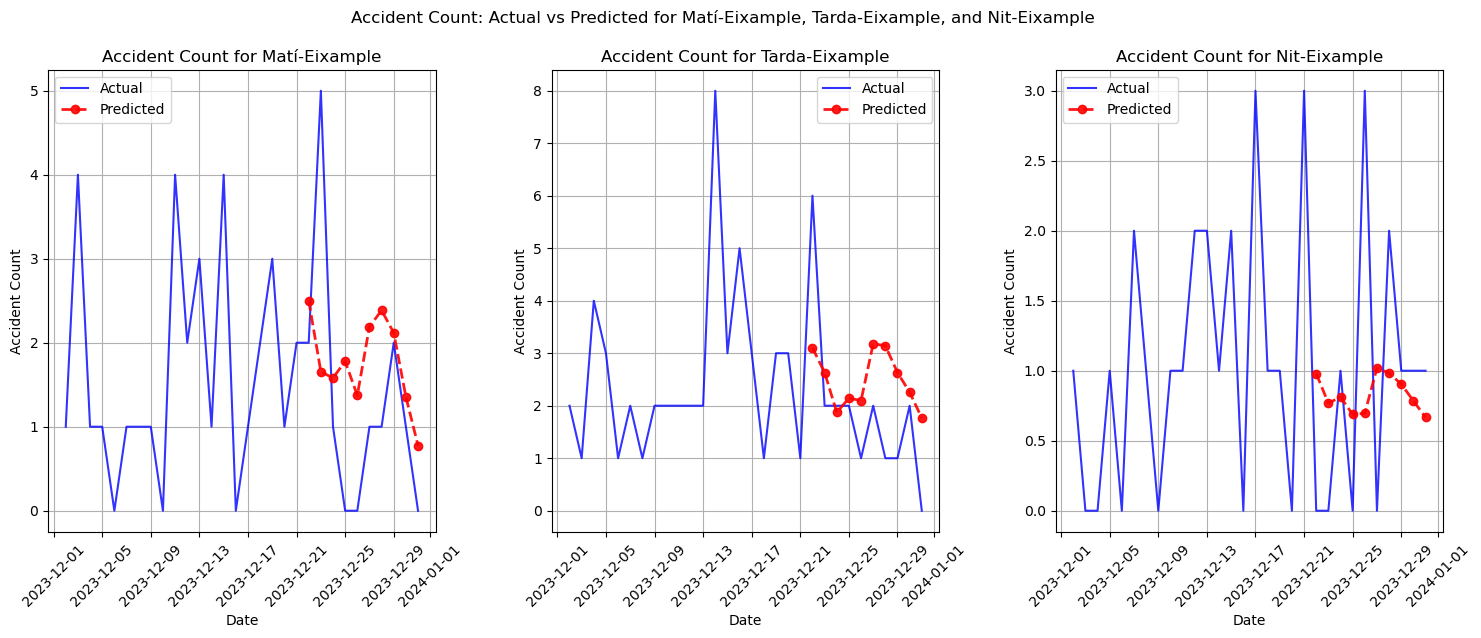

In [60]:
# Predict with the individual models
lgb_preds = lgb_model.predict(X_test)
cb_preds = cb_model.predict(X_test)

# Weighted mean of the predictions
mean_preds = (lgb_preds * 0.5 + cb_preds * 0.5)

# Add to test df
test['prediction'] = mean_preds

## Create the plot with a 3-column layout
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 3, figure=fig, wspace=0.3)

for i, unique_id in enumerate(['Matí-Eixample', 'Tarda-Eixample', 'Nit-Eixample']):
    ax = fig.add_subplot(gs[0, i])
    
    # Filter data for the current unique_id and select the last 30 days
    df_id = df_sorted.loc[unique_id]
    df_id_last_30_days = df_id.tail(30)
    
    # Plot actual values for the last 30 days
    ax.plot(df_id_last_30_days['date'], df_id_last_30_days['accident_count'], label='Actual', color='blue', linewidth=1.5, alpha=0.8)
    
    # Plot predicted values for the last 30 days
    test_id = test.loc[unique_id]
    test_id_last_30_days = test_id.tail(30)
    ax.plot(test_id_last_30_days['date'], test_id_last_30_days['prediction'], linestyle='--', label='Predicted', color='red', linewidth=2, marker='o', alpha=0.9)
    
    # Set title and labels
    ax.set_title(f'Accident Count for {unique_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Accident Count')
    ax.legend()
    ax.grid(True)
    
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Accident Count: Actual vs Predicted for Matí-Eixample, Tarda-Eixample, and Nit-Eixample')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./viz/predictions.png")
plt.show()
